In [107]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
#print(os.getcwd())
#if os.path.basename(os.getcwd()) != 'NeuroCurve': os.chdir('NeuroCurve')

## Processing

In [108]:
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")
"Drops any unnecessary features of the original dataset"
def pre_process():
    usableCSV = NeuroCurveOG.drop(columns=["PatientID", "Diabetes", "CardiovascularDisease", "DoctorInCharge", "Depression", "Depression", "SystolicBP", "DiastolicBP"])
    usableCSV.to_csv('CSV/output_CSVs/processed.csv')
pre_process()
usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')

X = usableCSV.drop(columns=['Diagnosis', 'Unnamed: 0'])
y = usableCSV['Diagnosis']

categorical_cols = ['Gender', 'Ethnicity', 'FamilyHistoryAlzheimers']
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding

''' Scale features '''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Model Test Split


In [109]:
''' ----------- Train/Test Split ----------- '''
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## Training

In [110]:
results = {}

''' ----------- Logistic Model Training ----------- '''
log = LogisticRegression(class_weight='balanced', max_iter=1000)
log.fit(X_train, y_train)
results['LogisticRegression'] = {'model':log,'accuracy':accuracy_score(y_test, log.predict(X_test)), 'y_prob':log.predict_proba(X_test), 'y_pred':log.predict(X_test), 'y_prob_class1':log.predict_proba(X_test)[:, 1]}
#print(f'Logistic Regression Accuracy: {results['LogisticRegression']['accuracy']* 100:.2f}%')

'''------------- Decision Tree Model Training ---------'''
tree = DecisionTreeClassifier(random_state=2028) # 93.02 = 2028
tree.fit(X_train, y_train)
results['DecisionTree'] = {'model':tree,'accuracy':accuracy_score(y_test, tree.predict(X_test)), 'y_prob':tree.predict_proba(X_test), 'y_pred':tree.predict(X_test), 'y_prob_class1':tree.predict_proba(X_test)[:, 1]}

'''------------ Mythical Forest Model Training---------'''
forest = RandomForestClassifier(max_features='sqrt', n_estimators=len(X_train), random_state=42)
forest.fit(X_train, y_train)
print("Number of trees in the Mythical Forest: " + str(len(forest.estimators_)))
results['RandomForest'] = {'model':forest,'accuracy':accuracy_score(y_test, forest.predict(X_test)), 'y_prob':forest.predict_proba(X_test), 'y_pred':forest.predict(X_test), 'y_prob_class1':forest.predict_proba(X_test)[:, 1]}

'''----------------Hist Gradient Boost Training--------'''
histGradient = HistGradientBoostingClassifier(max_iter=300)
histGradient.fit(X_train, y_train)
results['HistGradientBoost'] = {'model':histGradient,'accuracy':accuracy_score(y_test, histGradient.predict(X_test)), 'y_prob':histGradient.predict_proba(X_test), 'y_pred':histGradient.predict(X_test), 'y_prob_class1':histGradient.predict_proba(X_test)[:, 1]}

'''----------------XG Boost Training-------------------------'''
xgBoost = XGBClassifier(n_estimators=len(X_train), eval_metric='logloss')
xgBoost.fit(X_train, y_train)
results['XGBoost'] = {'model':xgBoost,'accuracy':accuracy_score(y_test, xgBoost.predict(X_test)), 'y_prob':xgBoost.predict_proba(X_test), 'y_pred':xgBoost.predict(X_test), 'y_prob_class1':xgBoost.predict_proba(X_test)[:, 1]}

#'''random n states'''
#import time
'''
def trym(n):
    tree = DecisionTreeClassifier(random_state=n) # 91.63 = 3
    tree.fit(X_train, y_train)
    #results['DecisionTree'] = {'accuracy':accuracy_score(y_test, tree.predict(X_test)), 'y_prob':tree.predict_proba(X_test), 'y_pred':tree.predict(X_test)}
    accuracy = accuracy_score(y_test, tree.predict(X_test))
    if((accuracy*100 > 93.01)or(n%1000 == 0)):
        #start = time.perf_counter()
        print(f'Decision Tree Accuracy at {n}: {accuracy* 100:.2f}%')
        #end = time.perf_counter()
        #runtime = end - start
        #print(f"Runtime: {runtime:.4f} seconds")
for i in range(11000, 20000):
    trym(i)'''

for model_name, metrics in results.items():
    print(f"{model_name}: {metrics['accuracy'] * 100:.2f}%")

Number of trees in the Mythical Forest: 1719
LogisticRegression: 81.40%
DecisionTree: 93.02%
RandomForest: 94.88%
HistGradientBoost: 95.35%
XGBoost: 94.88%


## Analysis

K-Fold Cross Validation

In [111]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for model_name, metrics in results.items():
    metrics['cross_val_score_mean'] = cross_val_score(metrics['model'], X_scaled, y, cv = kf, scoring='accuracy').mean()
    print(f'Cross-validated {model_name} accuracy: {results[model_name]['cross_val_score_mean']}')

Cross-validated LogisticRegression accuracy: 0.8208432949358835
Cross-validated DecisionTree accuracy: 0.8953053683981743
Cross-validated RandomForest accuracy: 0.9502086502934144
Cross-validated HistGradientBoost accuracy: 0.9506715931319277
Cross-validated XGBoost accuracy: 0.9488111280156488


## Visualization

### Confusion Matrix

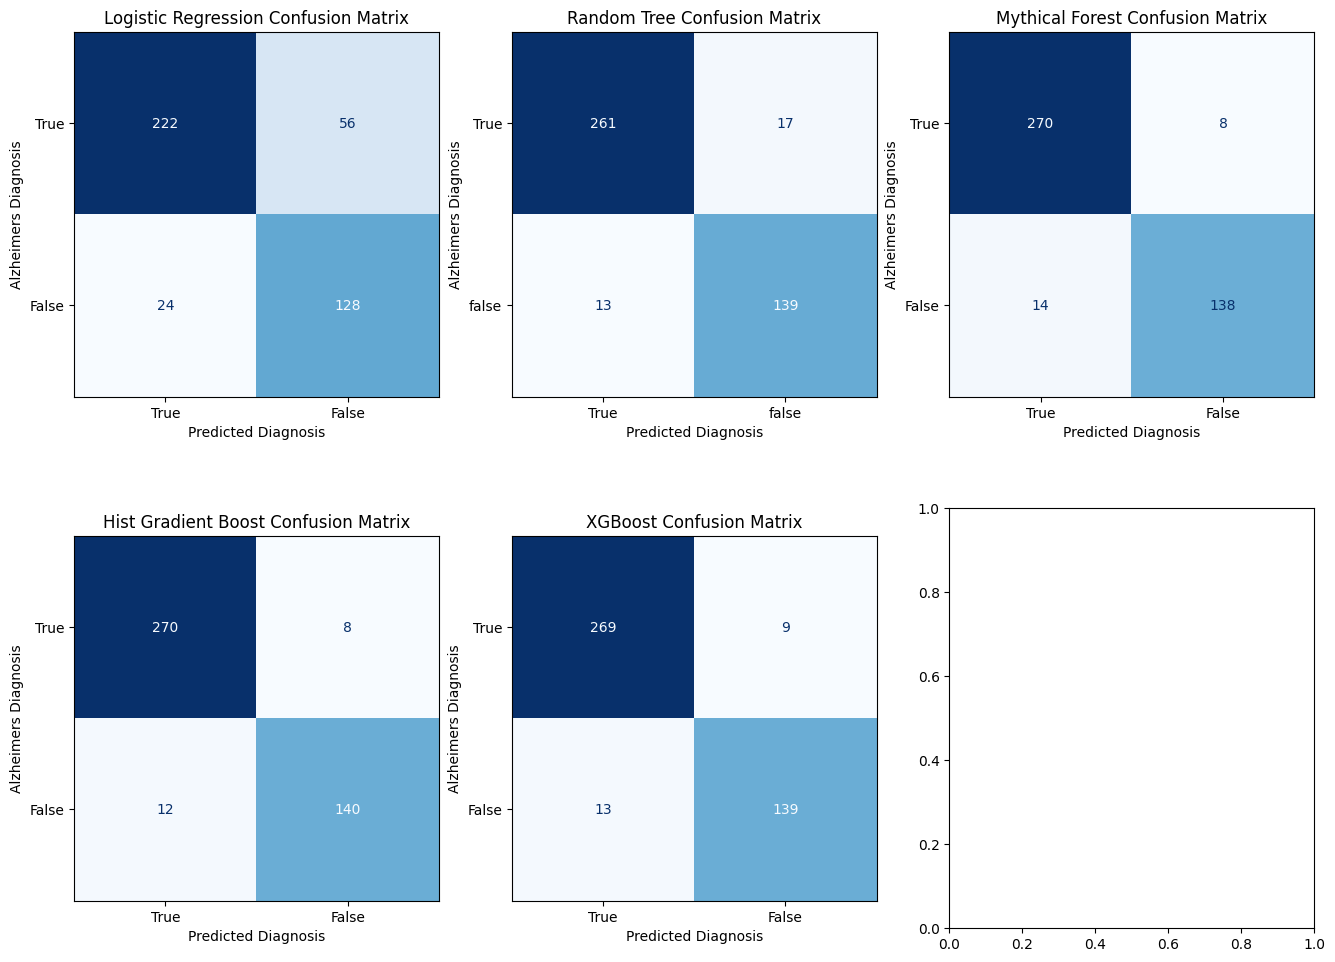

In [112]:
figs, axes = plt.subplots(2, 3, figsize=(16,12))

''' ----------- Logistic Model Confusion Matrix ----------- '''
cm = confusion_matrix(y_test, results['LogisticRegression']['y_pred'])
disp1 = ConfusionMatrixDisplay(cm, display_labels=["True", "False"])
disp1.plot(ax=axes[0][0], colorbar=False, cmap="Blues")

axes[0][0].set_title("Logistic Regression Confusion Matrix")
axes[0][0].set_ylabel("Alzheimers Diagnosis")
axes[0][0].set_xlabel("Predicted Diagnosis")

'''------------- Decision Tree Model  Confusion Matrix ---------'''
cm1 = confusion_matrix(y_test, results['DecisionTree']['y_pred'])
disp2= ConfusionMatrixDisplay(cm1, display_labels=["True", "false"])
disp2.plot(ax=axes[0][1], colorbar=False, cmap="Blues")

axes[0][1].set_title("Random Tree Confusion Matrix")
axes[0][1].set_ylabel("Alzheimers Diagnosis")
axes[0][1].set_xlabel("Predicted Diagnosis")

'''------------ Mythical Forest Model  Confusion Matrix ---------'''
cm2 = confusion_matrix(y_test, results['RandomForest']['y_pred'])
disp3 = ConfusionMatrixDisplay(cm2, display_labels=["True", "False"])
disp3.plot(ax=axes[0][2], colorbar=False, cmap="Blues")

axes[0][2].set_title("Mythical Forest Confusion Matrix")
axes[0][2].set_ylabel("Alzheimers Diagnosis")
axes[0][2].set_xlabel("Predicted Diagnosis")

'''------------ Hist Gradient Boost Model  Confusion Matrix ---------'''
cm = confusion_matrix(y_test, results['HistGradientBoost']['y_pred'])
disp4 = ConfusionMatrixDisplay(cm, display_labels=["True", "False"])
disp4.plot(ax=axes[1][0], colorbar=False, cmap="Blues")

axes[1][0].set_title("Hist Gradient Boost Confusion Matrix")
axes[1][0].set_ylabel("Alzheimers Diagnosis")
axes[1][0].set_xlabel("Predicted Diagnosis")

'''------------ XGBoost Model  Confusion Matrix ---------'''
cm = confusion_matrix(y_test, results['XGBoost']['y_pred'])
disp5 = ConfusionMatrixDisplay(cm, display_labels=["True", "False"])
disp5.plot(ax=axes[1][1], colorbar=False, cmap="Blues")

axes[1][1].set_title("XGBoost Confusion Matrix")
axes[1][1].set_ylabel("Alzheimers Diagnosis")
axes[1][1].set_xlabel("Predicted Diagnosis")
plt.show()

### Classification Reports

In [113]:
for model_name, metrics in results.items():
    metrics['report'] = classification_report(y_test, metrics['y_pred'])
    
for model_name, metrics in results.items():
    print(f"{model_name} Classification Report:")
    print(metrics['report'])
    print('-' * 53)

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       278
           1       0.70      0.84      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.80       430
weighted avg       0.83      0.81      0.82       430

-----------------------------------------------------
DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       278
           1       0.89      0.91      0.90       152

    accuracy                           0.93       430
   macro avg       0.92      0.93      0.92       430
weighted avg       0.93      0.93      0.93       430

-----------------------------------------------------
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1   

### Receiver Operating Characteristic Curves

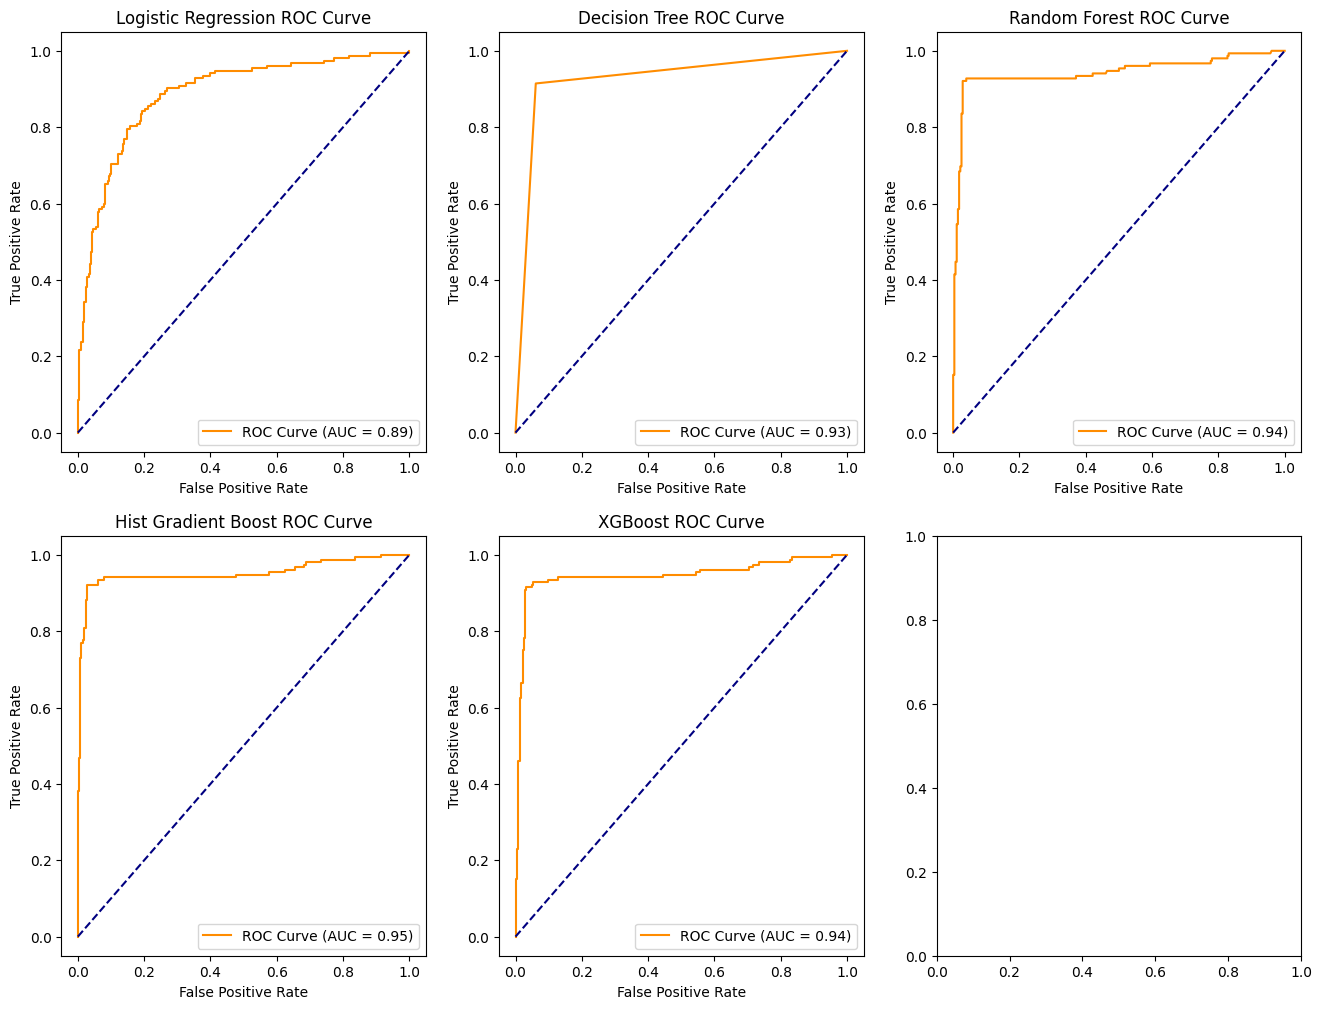

In [114]:
figs, axes = plt.subplots(2, 3, figsize=(16,12))

''' ----------- Logistic Model ROC Curve ----------- '''
fpr, tpr, thresholds = roc_curve(y_test, results['LogisticRegression']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['LogisticRegression']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['LogisticRegression']['y_prob_class1'])
axes[0][0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
axes[0][0].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[0][0].set_xlabel('False Positive Rate')
axes[0][0].set_ylabel('True Positive Rate')
axes[0][0].set_title('Logistic Regression ROC Curve')
axes[0][0].legend(loc="lower right")

'''------------- Decision Tree Model Training ---------'''
fpr, tpr, thresholds = roc_curve(y_test, results['DecisionTree']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['DecisionTree']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['DecisionTree']['y_prob_class1'])
axes[0][1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
axes[0][1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[0][1].set_xlabel('False Positive Rate')
axes[0][1].set_ylabel('True Positive Rate')
axes[0][1].set_title('Decision Tree ROC Curve')
axes[0][1].legend(loc="lower right")

'''------------ Mythical Forest Model Training---------'''
fpr, tpr, thresholds = roc_curve(y_test, results['RandomForest']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['RandomForest']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['RandomForest']['y_prob_class1'])
axes[0][2].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
axes[0][2].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[0][2].set_xlabel('False Positive Rate')
axes[0][2].set_ylabel('True Positive Rate')
axes[0][2].set_title('Random Forest ROC Curve')
axes[0][2].legend(loc="lower right")

'''------------ Hist Gradient Boost Model Training---------'''
fpr, tpr, thresholds = roc_curve(y_test, results['HistGradientBoost']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['HistGradientBoost']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['HistGradientBoost']['y_prob_class1'])
axes[1][0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
axes[1][0].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1][0].set_xlabel('False Positive Rate')
axes[1][0].set_ylabel('True Positive Rate')
axes[1][0].set_title('Hist Gradient Boost ROC Curve')
axes[1][0].legend(loc="lower right")

'''------------ XGBoost Model Training---------'''
fpr, tpr, thresholds = roc_curve(y_test, results['XGBoost']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['XGBoost']['y_prob_class1'])
roc_auc = roc_auc_score(y_test, results['XGBoost']['y_prob_class1'])
axes[1][1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
axes[1][1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1][1].set_xlabel('False Positive Rate')
axes[1][1].set_ylabel('True Positive Rate')
axes[1][1].set_title('XGBoost ROC Curve')
axes[1][1].legend(loc="lower right")